# Import Modules

In [1]:
%tensorflow_version 2.x
%matplotlib inline

from os import path                      # os level path manipulation
from glob import glob                    # Unix style pathname pattern expansion
import numpy as np                       # array goodnes
from matplotlib import pyplot as plt     # plotting library
import nibabel as nib                    # handlie NIFTI files
from tqdm import tqdm, trange            # progress bars
from tensorflow.keras.utils import get_file  # handy function to download data

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

TensorFlow 2.x selected.


# Load Data
The data-set is derived from the Automated Cardiac Diagnosis challenge (ACDC). The data-set provides the following classes for semantic segmentation:

  0. background
  1. right ventricular cavity
  2. left ventricular myocardium
  3. left ventricular cavity

![acdc logo]

## Imaging Technique
> The acquisitions were obtained over a 6 year period using two MRI scanners of different magnetic strengths (1.5 T (Siemens Area, Siemens Medical Solutions, Germany) and 3.0 T (Siemens Trio Tim, Siemens Medical Solutions, Germany)). Cine MR images were acquired in breath hold with a retrospective or prospective gating and with a SSFP sequence in short axis orientation. Particularly, a series of short axis slices cover the LV from the base to the apex, with a thickness of 5 mm (or sometimes 8 mm) and sometimes an interslice gap of 5 mm (then one image every 5 or 10 mm, according to the examination). The spatial resolution goes from 1.37 to 1.68 mm2/pixel and 28 to 40 images cover completely or partially the cardiac cycle (in the second case, with prospective gating, only 5 to 10 % of the end of the cardiac cycle was omitted), all depending on the patient.  
([source][data set information])


[acdc logo]: https://acdc.creatis.insa-lyon.fr/description/files/illustrationChallengeACDC.png
[data set information]: https://acdc.creatis.insa-lyon.fr/description/databases.html

In [2]:
from skimage.transform import resize             # resize images
from skimage.exposure import equalize_adapthist  # CLAHE
from skimage.exposure import rescale_intensity   # used to normalize the image data
from sklearn.model_selection import train_test_split    # helper function to split the data

target_shape = (128, 128)
data_fn = get_file('acdc.tgz', 'https://bitbucket.org/hbwinther/data/downloads/acdc.tgz', extract=True)
basepath = path.split(data_fn)[0]

X, Y = [], []
for fn in tqdm(glob(path.join(basepath, 'img', '*.nii.gz')), desc='pre-processing'):
  root, cn = path.split(fn)

  #load image
  img = nib.load(fn)
  im = img.get_data()
  im = resize(im, target_shape, preserve_range=True)
  im = rescale_intensity(im, 'image', (-1.0, 1.0))
  im = np.expand_dims(im, -1)

  # load mask
  mask = nib.load(path.join(basepath, 'mask', cn))
  ma = mask.get_data().astype(np.uint8)
  ma = resize(ma, target_shape, order=0, preserve_range=True, anti_aliasing=False) # nearest neighbor
  ma_onehot = []
  for cls in [0, 1, 2, 3]:
    ma_onehot.append(ma == cls)
  ma_onehot = np.stack(ma_onehot, axis=-1)

  X.append(im)
  Y.append(ma_onehot)

X, Y = np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

pre-processing: 100%|██████████| 1902/1902 [00:18<00:00, 101.90it/s]


# Inspect the Dataset

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

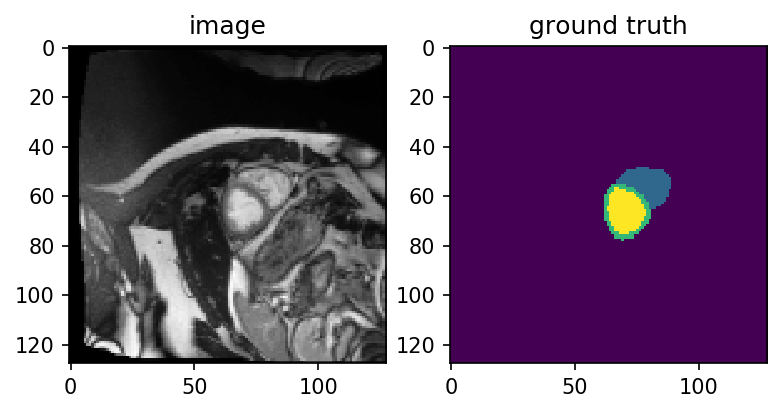

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

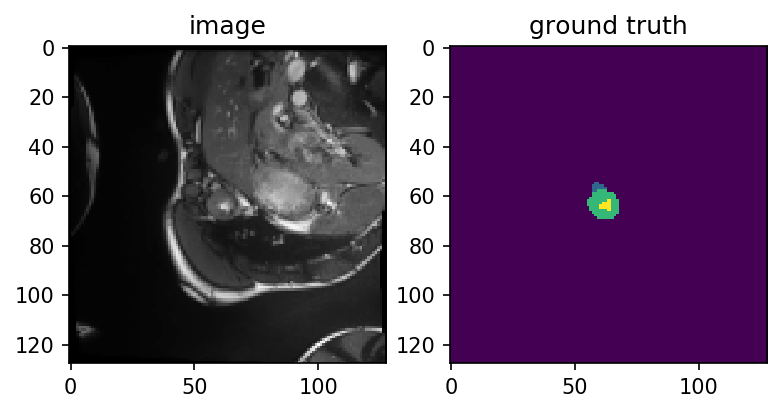

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

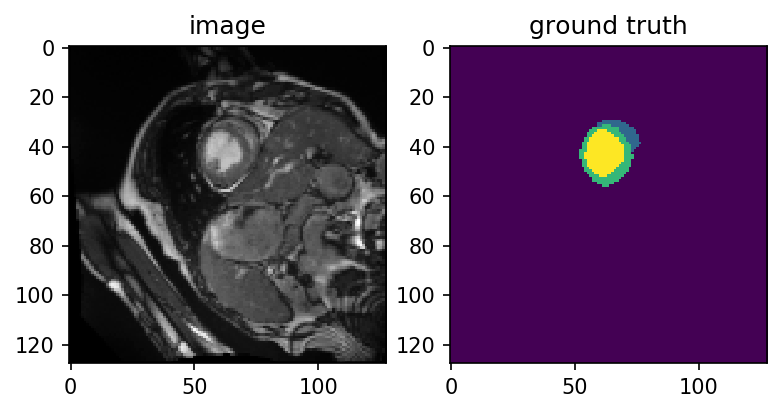

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

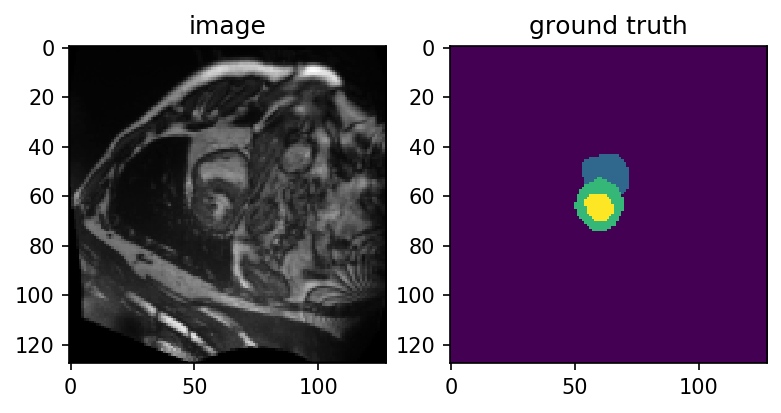

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

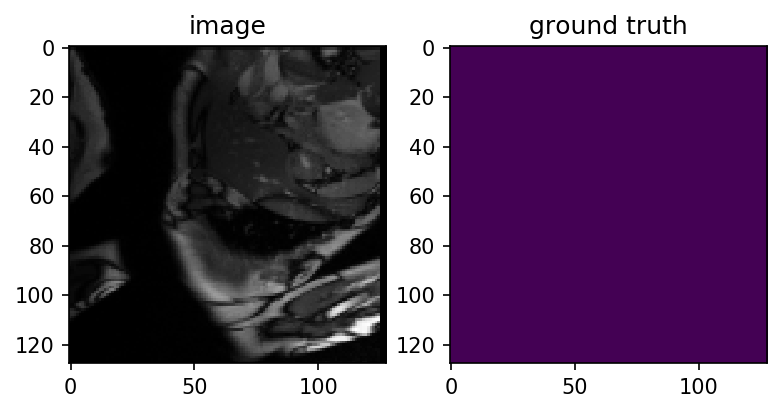

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

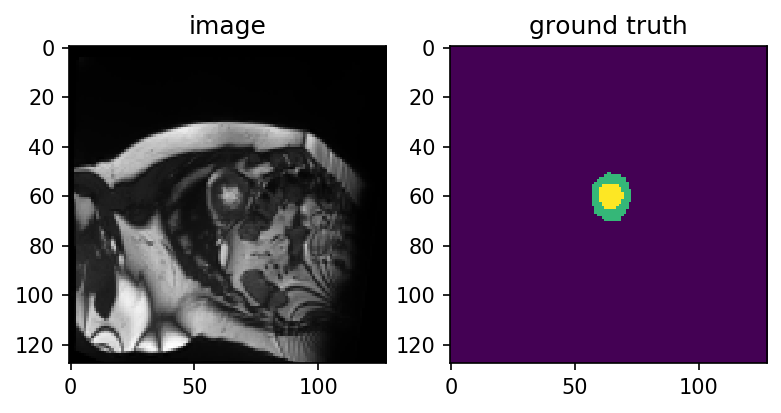

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

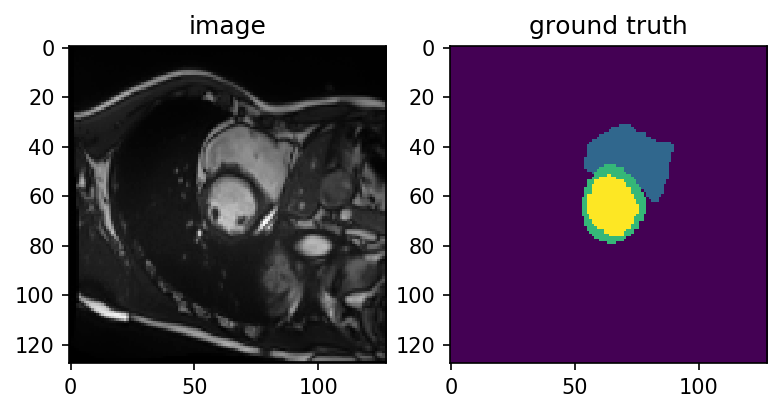

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

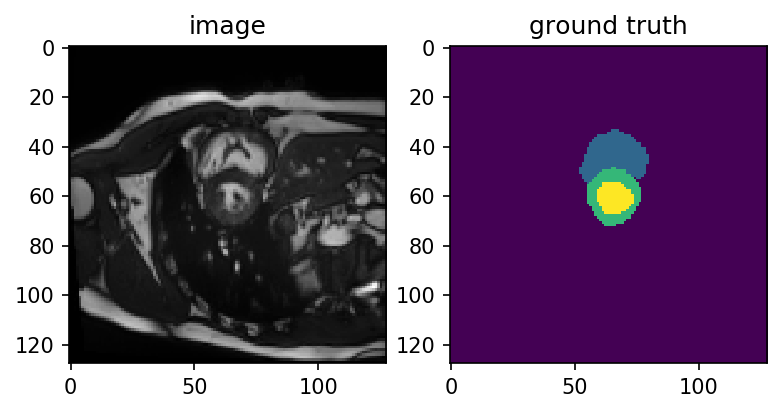

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

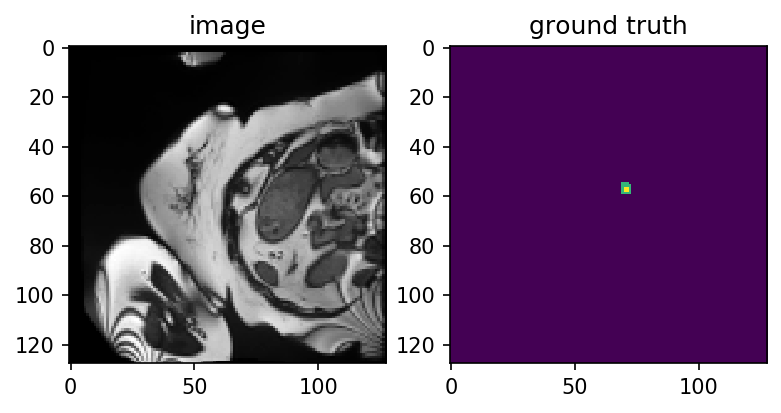

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

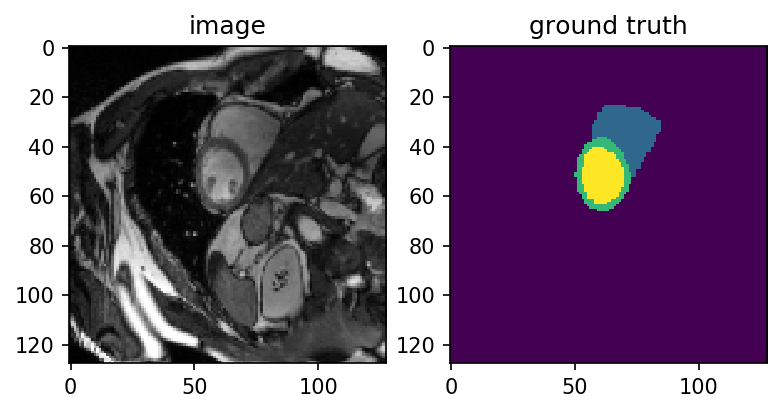

<IPython.core.display.Javascript object>

In [3]:
from google.colab import widgets

def plot(x, y, p=None, n=10):
    tb = widgets.TabBar([str(i) for i in range(len(x))][:n], location='top')
    for i in range(len(x))[:n]:
        image = x[i][...,0]
        truth = np.argmax(y[i], axis=-1)
        if p is not None: 
            prediction = np.argmax(p[i], axis=-1)
        with tb.output_to(i):
            if p is not None: fig, axs = plt.subplots(1,3)
            else:             fig, axs = plt.subplots(1,2)
            axs[0].imshow(image, cmap='Greys_r')
            axs[0].set_title('image')
            axs[1].imshow(truth, vmin=0, vmax=3)
            axs[1].set_title('ground truth')
            if p is not None:
                axs[2].imshow(prediction)
                axs[2].set_title('prediction')
            for ax in axs:
                ax.grid(False)

plot(X_train, Y_train)

# Define Network Topology

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [0]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, concatenate, AveragePooling2D
from tensorflow.keras.layers import UpSampling2D, BatchNormalization

channels_per_level = [32, 64, 128, 256]
bridge_channels = channels_per_level.pop()
identities = []
input_tensor = Input(shape=target_shape + (1,))
net = input_tensor

# encoder
for channels in channels_per_level:
    net = BatchNormalization(momentum=0.9)(net)
    net = Conv2D(channels, 3, padding='same', activation='relu')(net)
    identities.append(net)
    net = AveragePooling2D(padding='same')(net)

# bridge
net = BatchNormalization(momentum=0.9)(net)
net = Conv2D(bridge_channels, 3, padding='same', activation='relu')(net)

# decoder
for channels in channels_per_level[::-1]:
    net = UpSampling2D()(net)
    net = concatenate([net, identities.pop()])
    net = BatchNormalization(momentum=0.9)(net)
    net = Conv2D(channels, 3, padding='same', activation='relu')(net)

# classification
n_classes = Y_train[0].shape[-1]
net = Conv2D(n_classes, 1, padding='same', activation='sigmoid')(net)

# Create the Model

In [0]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model


#https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


learning_rate = 1e-3
model = Model(input_tensor, net)
model.compile(loss='binary_crossentropy',
              metrics=[dice_coef],
              optimizer=keras.optimizers.Adam(lr=learning_rate))

# Train the Model

In [6]:
model.fit(X_train, Y_train, 
          validation_data=[X_val, Y_val],
          epochs=3, batch_size=1)

Train on 1711 samples, validate on 191 samples
Epoch 1/3
1711/1711 [==============================] - 17s 10ms/sample - loss: 0.0296 - dice_coef: 0.9673 - val_loss: 0.0202 - val_dice_coef: 0.9820
Epoch 2/3
1711/1711 [==============================] - 12s 7ms/sample - loss: 0.0129 - dice_coef: 0.9853 - val_loss: 0.0179 - val_dice_coef: 0.9842
Epoch 3/3
1711/1711 [==============================] - 13s 7ms/sample - loss: 0.0099 - dice_coef: 0.9887 - val_loss: 0.0175 - val_dice_coef: 0.9875


In [7]:
predictions = []
for i in trange(len(X_val)):
    im = X_val[i]
    im = im.reshape((1,)+im.shape)
    prediction = model.predict(im)[0]
    predictions.append(prediction)
predictions = np.array(predictions)

100%|██████████| 191/191 [00:04<00:00, 38.95it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

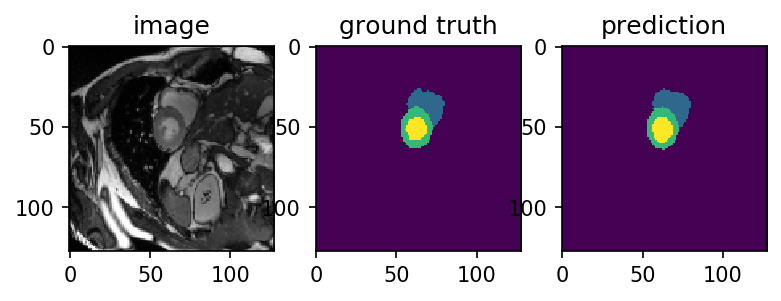

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

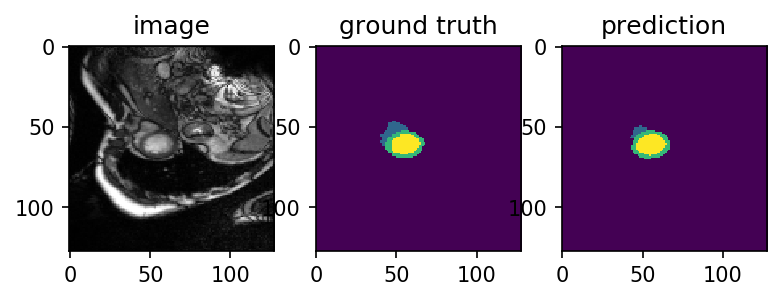

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

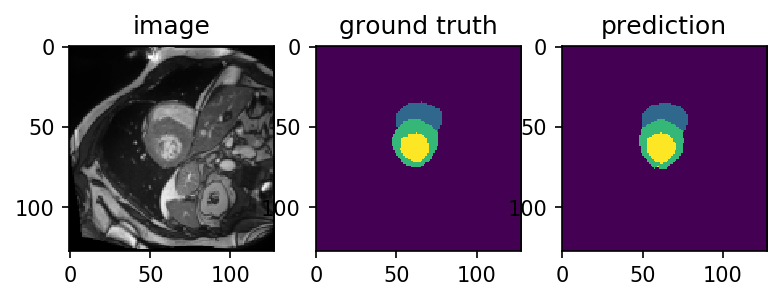

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

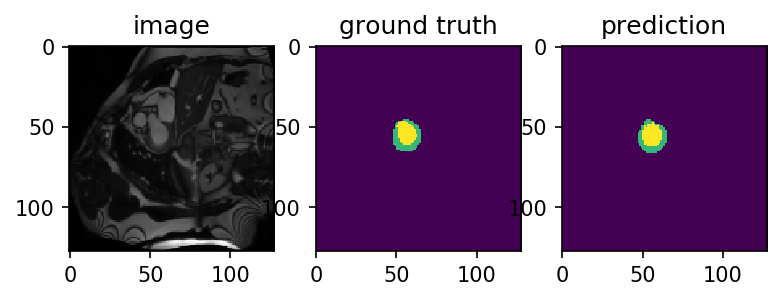

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

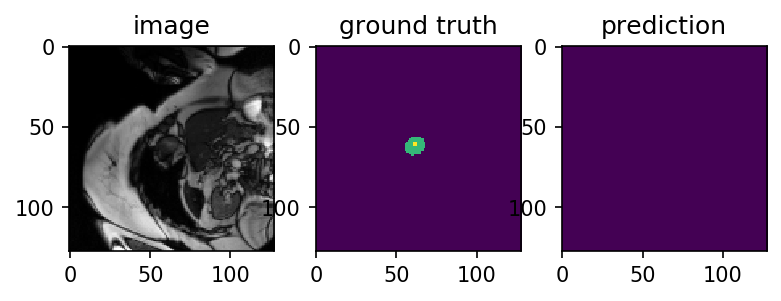

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

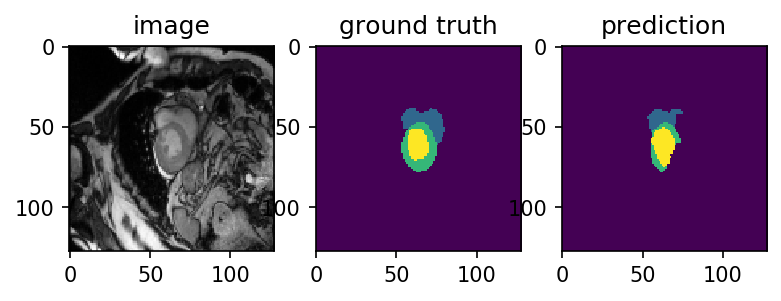

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

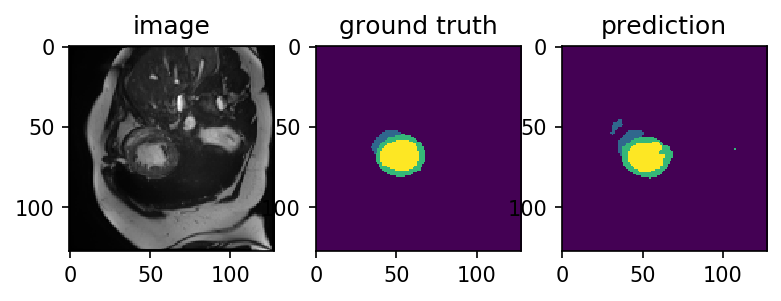

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

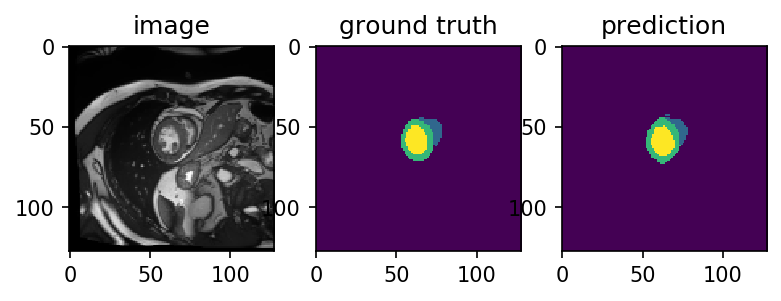

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

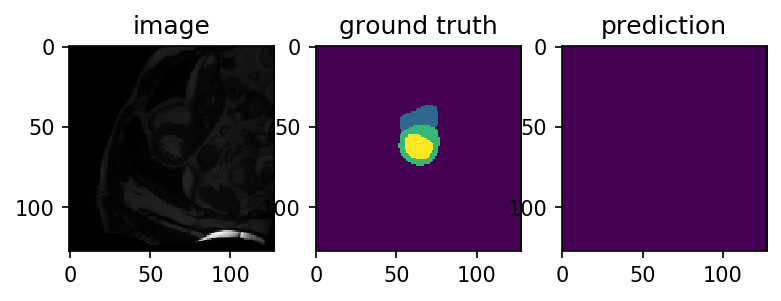

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

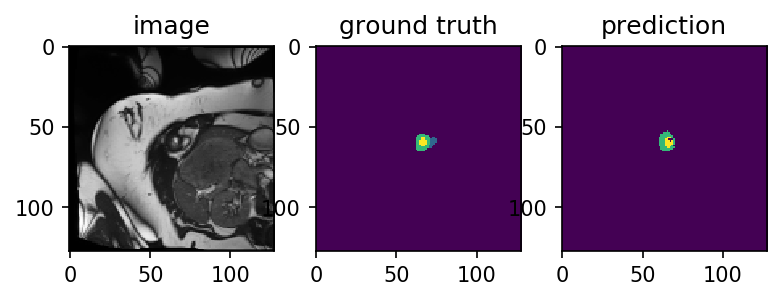

<IPython.core.display.Javascript object>

In [9]:
plot(X_val, Y_val, predictions)

# HANDS ON

## First
Examine the reproducibility of the results. Does the neural network always deliver the same performance?

## Second:
Identify the grave error in the setup of this experiment. To get a hint, hover over the light bulb symbol:  
![hint](https://upload.wikimedia.org/wikipedia/commons/f/fd/Oxygen480-actions-help-hint.svg "check for leakage in the train/validation split!")

## Third
Try to tune different hyperparameters: 
  - How does the input shape of the images impact training performance?
  - Does a deeper architecture yield better results?
  - How about a wider architecture?
  - Do more conv layers per down-/upsample step change the result?

## Fourth
Implement data augmentaion by mirroring the input data along both axis.